In [435]:
!pip install -q opencv-python mediapipe scikit-learn matplotlib seaborn scikeras

In [251]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [72]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [73]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles #drawing styles

In [88]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                 # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [75]:
def draw_styled_landmarks(image, results):
    
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             None,
                             connection_drawing_spec=mp.solutions.drawing_styles
                            .get_default_face_mesh_tesselation_style()
                             ) 
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             None,
                             connection_drawing_spec=mp.solutions.drawing_styles
                            .get_default_face_mesh_contours_style()
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 


In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #Read feed
        ret, frame = cap.read()

        #Make Detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        #Show feed
        cv2.imshow('WebCam Feed', image)

        #Escape from loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [8]:
draw_styled_landmarks(frame, results)

In [10]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

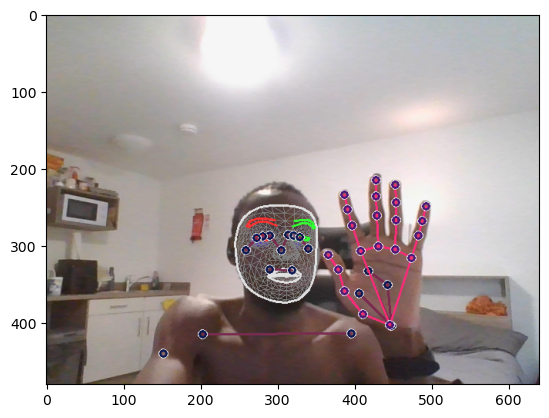

In [18]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [76]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [12]:
result_test = extract_keypoints(results)

In [13]:
np.save('0', result_test)

In [491]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('SLR_Data') 

# Actions that we try to detect
actions = np.array(['Always', 'Maybe', 'Should', 'Useful', 'Meet', 'Please'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [492]:
for action in actions: 
#     dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        path = os.path.join(DATA_PATH, action, str(sequence))
        if not os.path.exists(path):
            try: 
                os.makedirs(path)
            except Exception as e:
                print('Error creating directory:', e)

In [90]:
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
# cap.set(cv2.CAP_PROP_FPS, 30)
# cap.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc(*'MJPG'))

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
     # Loop through actions
    for action in actions: 
        
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num) + '.npy')
                
                # Check if directory already exists
                if not os.path.exists(npy_path):
                    #Read feed
                    ret, frame = cap.read()

                    #Make Detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)

                    # NEW Apply wait logic
                    if frame_num == 0: 
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        cv2.waitKey(900)
                    else:
#                         cv2.waitKey(500)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                     #Show feed
                    cv2.imshow('WebCam Feed', image)
                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                #Escape from loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                   
    cap.release()
    cv2.destroyAllWindows()

In [24]:
cap.release()
cv2.destroyAllWindows()

In [532]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [533]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Always': 0, 'Maybe': 1, 'Should': 2, 'Useful': 3, 'Meet': 4, 'Please': 5}

In [534]:
sequences, labels = [], []
for action in actions:
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [519]:
X = np.array(sequences)
X.shape

(180, 30, 1662)

In [535]:
y = to_categorical(labels).astype(int)
print('y', to_categorical(labels)[61])

y [0. 0. 1. 0. 0. 0.]


In [536]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [499]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [441]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load and preprocess your data
X_train = np.array(X_train)
y_train = np.array(y_train)

# Define your LSTM model function
def lstm_model(units, learning_rate):
    model = keras.Sequential()
    model.add(layers.LSTM(units, input_shape=(30, 1662)))
    model.add(layers.Dense(6, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define hyperparameters to search
units_values = [32, 64, 128, 256, 512]
learning_rate_values = [0.01, 0.001, 0.0001]

best_accuracy = 0.0
best_hyperparameters = {}

# Iterate over hyperparameters
for units in units_values:
    for learning_rate in learning_rate_values:
        print(f"Training model with units={units}, learning_rate={learning_rate}")

        # Create and compile the model
        model = lstm_model(units, learning_rate)

        # Train the model
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

        # Evaluate the model (You may need to split your data into train and validation sets)
        # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
        print(f"Validation Accuracy: {accuracy}")

        # Check if this is the best model so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {'units': units, 'learning_rate': learning_rate}

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)


Training model with units=32, learning_rate=0.01
1/1 [==============================] - 0s 295ms/step
Validation Accuracy: 0.1111111111111111
Training model with units=32, learning_rate=0.001
1/1 [==============================] - 0s 282ms/step
Validation Accuracy: 0.4444444444444444
Training model with units=32, learning_rate=0.0001
1/1 [==============================] - 0s 286ms/step
Validation Accuracy: 0.5555555555555556
Training model with units=64, learning_rate=0.01
1/1 [==============================] - 0s 289ms/step
Validation Accuracy: 0.2222222222222222
Training model with units=64, learning_rate=0.001
1/1 [==============================] - 0s 298ms/step
Validation Accuracy: 0.3333333333333333
Training model with units=64, learning_rate=0.0001
1/1 [==============================] - 0s 285ms/step
Validation Accuracy: 0.6666666666666666
Training model with units=128, learning_rate=0.01
1/1 [==============================] - 0s 347ms/step
Validation Accuracy: 0.3333333333333333

In [443]:
best_hyperparameters = {'units': 128, 'learning_rate': 0.001}

# Create the model with the best hyperparameters
model = lstm_model(**best_hyperparameters)

# Train the model while monitoring validation performance
best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1)

    # Evaluate the model on validation data (You may need to split your data into train and validation sets)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    y_pred = model.predict(X_test)
    val_accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print(f"Epoch {epoch + 1} - Validation Accuracy: {val_accuracy}")

    # Check if this epoch achieved the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1

print("Best Epoch:", best_epoch)
print("Best Validation Accuracy:", best_val_accuracy)

1/1 [==============================] - 0s 293ms/step
Epoch 1 - Validation Accuracy: 0.1111111111111111
1/1 [==============================] - 0s 19ms/step
Epoch 2 - Validation Accuracy: 0.3333333333333333
1/1 [==============================] - 0s 19ms/step
Epoch 3 - Validation Accuracy: 0.4444444444444444
1/1 [==============================] - 0s 21ms/step
Epoch 4 - Validation Accuracy: 0.6666666666666666
1/1 [==============================] - 0s 19ms/step
Epoch 5 - Validation Accuracy: 0.4444444444444444
1/1 [==============================] - 0s 30ms/step
Epoch 6 - Validation Accuracy: 0.7777777777777778
1/1 [==============================] - 0s 20ms/step
Epoch 7 - Validation Accuracy: 0.4444444444444444
1/1 [==============================] - 0s 20ms/step
Epoch 8 - Validation Accuracy: 0.6666666666666666
1/1 [==============================] - 0s 19ms/step
Epoch 9 - Validation Accuracy: 0.8888888888888888
1/1 [==============================] - 0s 18ms/step
Epoch 10 - Validation Accurac

1/1 [==============================] - 0s 21ms/step
Epoch 45 - Validation Accuracy: 1.0
1/1 [==============================] - 0s 20ms/step
Epoch 46 - Validation Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Epoch 47 - Validation Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Epoch 48 - Validation Accuracy: 1.0
1/1 [==============================] - 0s 20ms/step
Epoch 49 - Validation Accuracy: 1.0
1/1 [==============================] - 0s 19ms/step
Epoch 50 - Validation Accuracy: 1.0
Best Epoch: 22
Best Validation Accuracy: 1.0


In [500]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [537]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,1662)))
# model.add(LSTM(128, return_sequences=True, activation='tanh'))
# model.add(LSTM(64, return_sequences=False, activation='tanh'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(32, activation='tanh'))
# model.add(Dense(actions.shape[0], activation='softmax'))

model = Sequential()
model.add(layers.LSTM(units, input_shape=(30, 1662)))
model.add(layers.Dense(6, activation='softmax'))

In [538]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [539]:
# loss_history = []
# accuracy_history = []
history = model.fit(X_train, y_train, epochs=22, validation_split=0.1, batch_size=32)

Epoch 1/22
5/5 [==============================] - 2s 152ms/step - loss: 1.8116 - accuracy: 0.2680 - val_loss: 1.7539 - val_accuracy: 0.3333
Epoch 2/22
5/5 [==============================] - 0s 32ms/step - loss: 1.5755 - accuracy: 0.5098 - val_loss: 1.4095 - val_accuracy: 0.5000
Epoch 3/22
5/5 [==============================] - 0s 31ms/step - loss: 1.2111 - accuracy: 0.6340 - val_loss: 1.1358 - val_accuracy: 0.3889
Epoch 4/22
5/5 [==============================] - 0s 32ms/step - loss: 0.9616 - accuracy: 0.5752 - val_loss: 1.0348 - val_accuracy: 0.5556
Epoch 5/22
5/5 [==============================] - 0s 29ms/step - loss: 0.8048 - accuracy: 0.6275 - val_loss: 0.7951 - val_accuracy: 0.8889
Epoch 6/22
5/5 [==============================] - 0s 29ms/step - loss: 0.6561 - accuracy: 0.8170 - val_loss: 0.8190 - val_accuracy: 0.6667
Epoch 7/22
5/5 [==============================] - 0s 30ms/step - loss: 0.5489 - accuracy: 0.7778 - val_loss: 0.5904 - val_accuracy: 0.9444
Epoch 8/22
5/5 [==========

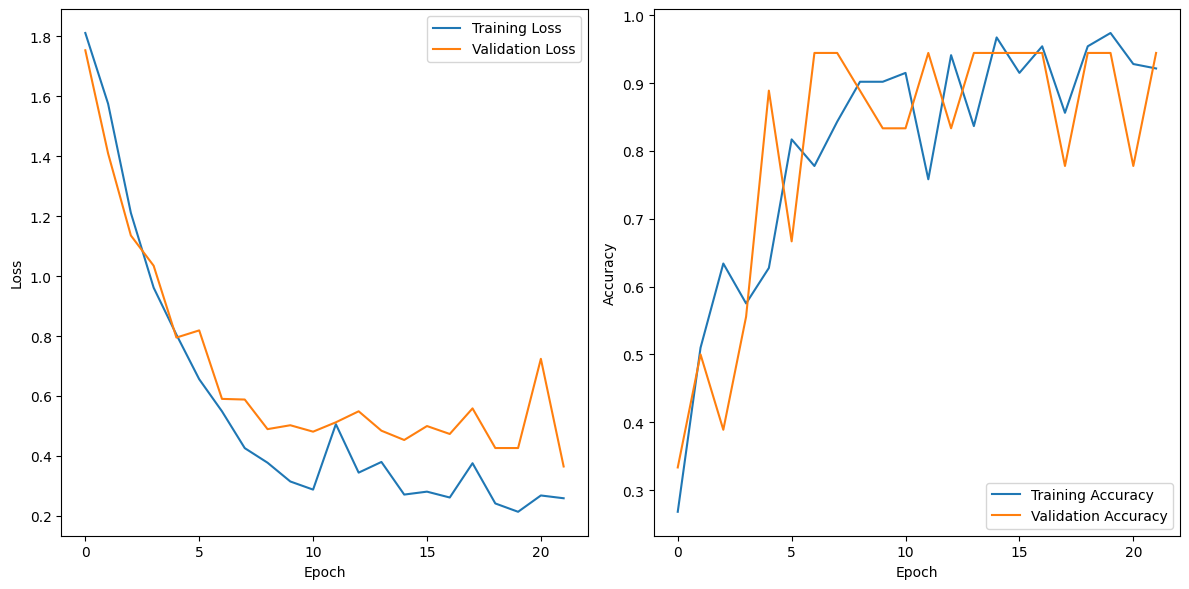

In [540]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [469]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 512)               4454400   
                                                                 
 dense_21 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 4,457,478
Trainable params: 4,457,478
Non-trainable params: 0
_________________________________________________________________


In [541]:
# Make predictions on the test data
res = model.predict(X_test)
# Assuming y_test is one-dimensional, you don't need to convert it.
# If y_test is one-hot encoded, you can convert y_pred to class labels.
y_pred_labels = np.argmax(res[0])

# Evaluate the model's predictions (e.g., calculate accuracy)
# Ensure y_pred_labels and y_test have compatible shapes and data types
accuracy = np.mean(y_pred_labels == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 327ms/step
Test accuracy: 83.33%


In [542]:
actions[np.argmax(res[0])]

'Always'

In [543]:
actions[np.argmax(y_test[0])]

'Always'

In [509]:
model.save('SLR.MODEL')

INFO:tensorflow:Assets written to: SLR.MODEL\assets


INFO:tensorflow:Assets written to: SLR.MODEL\assets


In [510]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [544]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 30ms/step


In [545]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

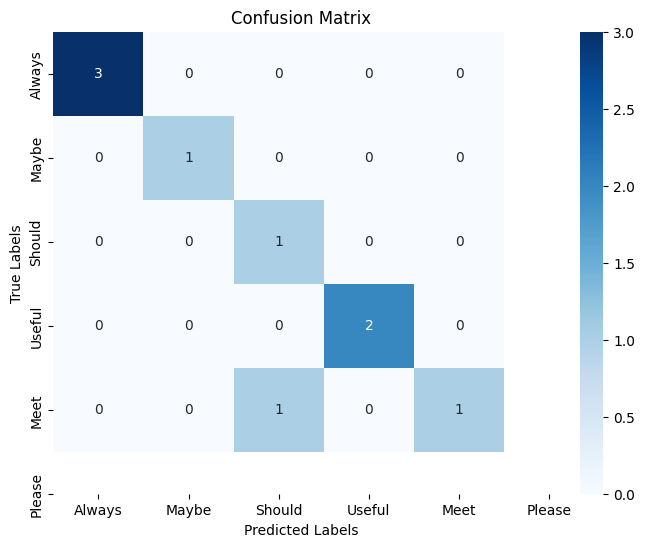

In [546]:
conf_matrix = confusion_matrix(ytrue, yhat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [547]:
accuracy = accuracy_score(ytrue, yhat)
print("Accurary:", accuracy)
precision = precision_score(ytrue, yhat, average='weighted')  # You can specify the averaging method: 'weighted', 'micro', 'macro', etc.
print("Precision:", precision)

# Calculate recall
recall = recall_score(ytrue, yhat, average='weighted')  # You can specify the averaging method.
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(ytrue, yhat, average='weighted')  # You can specify the averaging method.
print("F1 Score:", f1)

Accurary: 0.8888888888888888
Precision: 0.9444444444444444
Recall: 0.8888888888888888
F1 Score: 0.8888888888888888


In [548]:
colors = [(245,117,16), (117,245,16), (16,117,245), (14, 200, 100), (300, 234, 58),(360, 55, 235)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
# cap.set(cv2.CAP_PROP_FPS, 30)
# cap.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc(*'MJPG'))
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5


# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

cap.release()
cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'media

1/1 [==============================] - 0s 20ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
Always
<class 'media

1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Always
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
Always
<class 'media

1/1 [==============================] - 0s 18ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
Maybe
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
Maybe
<class 'mediapipe.pyth